# Requirements

In [8]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

# Shapes

Simple geometric shapes are defined as `namedtuple`s, e.g., a square and a circle.

In [2]:
Square = namedtuple('square', ['x', 'y', 'delta_x', 'delta_y'])

In [3]:
Circle = namedtuple('circle', ['x', 'y', 'r'])

# The prison

The prison has outer walls that form a square, and a square building that is situated in the middle of the prison grounds.  The length of the walls of the outer walls is 12, that of the building's walls is 4.

In [17]:
walls = Square(x=0.0, y=0.0, delta_x=12.0, delta_y=12.0)

In [18]:
building = Square(x=4.0, y=4.0, delta_x=4.0, delta_y=4.0)

# Geometries

A geometry is defined as a function that takes $x$ and $y$ coordinates as parameters, and that returns `True` if that point is free, i.e., it is inside of the outer walls, but not in the building on the yard. 

In [21]:
def create_square_in_square_geometry(outer_square, inner_square):
    def is_free_coordinate(x, y):
        is_in_outer_square = (outer_square.x <= x <= outer_square.x + outer_square.delta_x and
                              outer_square.y <= y <= outer_square.y + outer_square.delta_y)
        is_in_inner_square = (inner_square.x <= x <= inner_square.x + inner_square.delta_x and
                              inner_square.y <= y <= inner_square.y + inner_square.delta_y)
        return is_in_outer_square and not is_in_inner_square
    return is_free_coordinate

In [22]:
geometry = create_square_in_square_geometry(walls, building)

For debugging purposes, it is convenient to have a function that displays a geometry.

In [12]:
def show_geometry(geometry, square, resolution=101):
    x = np.linspace(square.x, square.delta_x, resolution)
    y = np.linspace(square.y, square.delta_y, resolution)
    X, Y = np.meshgrid(x, y)
    shape = np.vectorize(geometry)(X, Y)
    plt.imshow(shape)

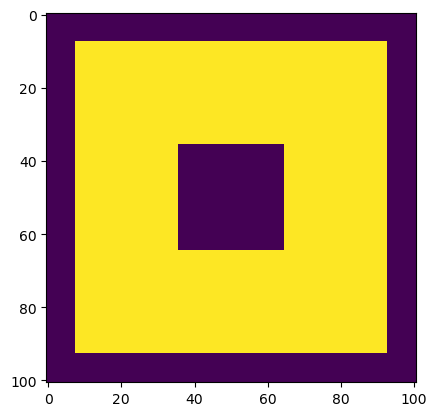

In [14]:
show_geometry(geometry, Square(x=-1.0, y=-1.0, delta_x=13.0, delta_y=13.0))

# The guard

The question is how much of the prison grounds a guard can see from a given position $x$, $y$.  First, we define a trace function that will compute the distance a guard can see when standing at $x$, $y$, looking in direction $\alpha$, given the geometry.

In [15]:
def trace(x, y, delta, alpha, geometry):
    length = 0.0
    delta_x, delta_y = delta*np.cos(alpha), delta*np.sin(alpha)
    while geometry(x + delta_x, y + delta_y):
        length += delta
        x += delta_x
        y += delta_y
    return length

When the guard stands in the corner, and looks towards the middle of the prison, facing the corner of the building, the distance should be $\sqrt{32}$.

In [19]:
trace(0.0, 0.0, 0.001, np.pi/4.0, geometry)

5.6560000000002235

In [20]:
np.sqrt(32.0)

5.656854249492381

When the guard stands in the corner, and looks outward, he faces the wall, so the distance should be 0.

In [16]:
trace(0.0, 0.0, 0.001, -np.pi/4.0, geometry)

0.0

The area visible to the guard can now be computed as the sum of the areas of small triangles.  The triangles are generated by letting the guard look at an angle $\alpha$ with a field of vision of $\Delta \alpha$.  The area of such a triangle is approximately $R(\alpha)^2 \Delta\alpha/2$, where $R(\alpha)$ is the distance the guard can see in direction $\alpha$.

In [24]:
def visible_area(x, y, geometry, delta_alpha, delta):
    if not geometry(x, y):
        return 0.0
    area = 0.0
    for alpha in np.arange(0.0, 2.0*np.pi, delta_alpha):
        area += trace(x, y, delta, alpha, geometry)**2
    return 0.5*area*delta_alpha

In [25]:
visible_area(0.0, 0.0, geometry, 0.001, 0.001)

87.98183054698586

In [36]:
visible_area(0.0, 4.0, geometry, 0.001, 0.001)

88.0004339404974

# Best and worst position

Where should the guard stand when his back is to one of the walls to see
  * the largest area, and
  * the smallest area?

In [28]:
xs, areas = [], []
for x in np.arange(0.0, 6.0, 0.05):
    xs.append(x)
    areas.append(visible_area(x, 0.0, geometry, 0.001, 0.001))

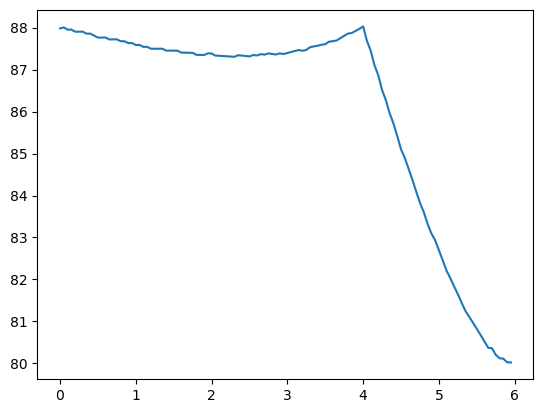

In [29]:
plt.plot(xs, areas);

The guard can survey the largest area either in the corner, or by opposite the corner of the building.  He sees the smallest area overal when facing the middle of the building, but also has suboptimal view around $x \approx 2.5$.